### 🔧 Установка необходимых библиотек

Здесь мы устанавливаем основные библиотеки, которые понадобятся для анализа данных и построения модели:
- `pandas` — работа с таблицами,
- `scikit-learn` — инструменты машинного обучения,
- `matplotlib`, `seaborn` — визуализация.


In [42]:
!pip install -q scikit-learn pandas matplotlib seaborn

### 📥 Загрузка датасета новостей

Скачиваем CSV-файл с GitHub, содержащий тексты и метки новостей. Этот датасет используется для задачи классификации фейковых и реальных новостей.


In [43]:
!wget https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv -O news.csv

--2025-07-26 18:56:30--  https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3103165 (3.0M) [text/plain]
Saving to: ‘news.csv’

news.csv            100%[===================>]   2.96M  --.-KB/s    in 0.08s   

2025-07-26 18:56:30 (35.0 MB/s) - ‘news.csv’ saved [3103165/3103165]



### 🧹 Предобработка и первичный анализ данных

Загружаем данные в `pandas.DataFrame`, переименовываем колонку `tweet` в `text`, чтобы она соответствовала нашему дальнейшему коду, и выводим первые строки таблицы.


In [44]:
import pandas as pd

# Загрузка CSV-файла
df = pd.read_csv("news.csv")

# Переименуем колонку 'tweet' в 'text' для удобства
df = df.rename(columns={'tweet': 'text'})

df.head()


,id,label,text
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


### ✂️ Разделение выборки и векторизация текста

- Делим данные на обучающую и тестовую выборки (90/10).
- Используем `TfidfVectorizer` для преобразования текстов в числовые векторы с учётом частоты и важности слов и биграмм.


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Отделим признаки (X) и целевую переменную (y)
X = df['text']
y = df['label']

# Разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

# Векторизация текста с помощью TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print("✅ Векторизация завершена. Размер матрицы признаков:")
print("Обучающая выборка:", X_train_tfidf.shape)
print("Тестовая выборка:", X_test_tfidf.shape)


✅ Векторизация завершена. Размер матрицы признаков:
Обучающая выборка: (28765, 38404)
Тестовая выборка: (3197, 38404)


### 🧠 Обучение модели Passive-Aggressive Classifier

Обучаем классификатор `PassiveAggressiveClassifier` с параметрами:
- `C=0.5` — регулировка силы регуляризации,
- `class_weight='balanced'` — учитываем дисбаланс классов.

Модель обучается на векторизованных данных.


In [47]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, classification_report

# Создание и обучение модели
model = PassiveAggressiveClassifier(max_iter=1000, C=0.5, class_weight='balanced')

model.fit(X_train_tfidf, y_train)

# Предсказания
y_pred = model.predict(X_test_tfidf)

# Оценка точности
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Точность модели: {accuracy:.2%}")

# Классификационный отчёт
print("\n📊 Отчёт классификации:")
print(classification_report(y_test, y_pred))


✅ Точность модели: 96.12%

📊 Отчёт классификации:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2984
           1       0.73      0.66      0.69       213

    accuracy                           0.96      3197
   macro avg       0.85      0.82      0.84      3197
weighted avg       0.96      0.96      0.96      3197



### 🧪 Проверка меток классов

Выводим уникальные значения в колонке `label`, чтобы убедиться, какие классы содержит датасет

In [ ]:
print("Уникальные значения меток:")
print(y_test.unique())


Уникальные значения меток:
[0 1]


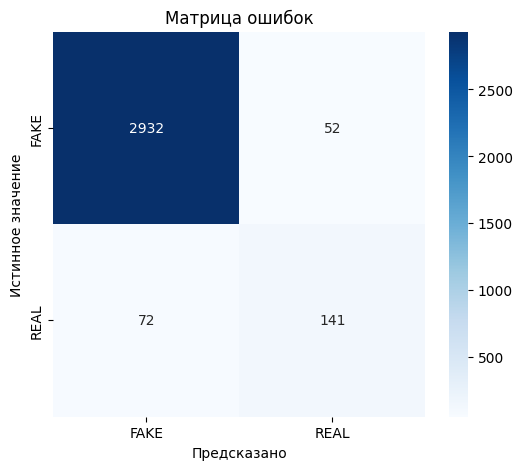

In [48]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Построение матрицы ошибок с числовыми метками
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Визуализация
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["FAKE", "REAL"],
            yticklabels=["FAKE", "REAL"])
plt.xlabel('Предсказано')
plt.ylabel('Истинное значение')
plt.title('Матрица ошибок')
plt.show()


Метки классов указаны вручную: `0` = FAKE, `1` = REAL.

#### 🤖 Улучшение модели с помощью ансамбля моделей (VotingClassifier)

Для дальнейшего повышения точности мы объединили две разные модели:
- `PassiveAggressiveClassifier` — быстрый и устойчивый онлайн-классификатор,
- `LinearSVC` — мощный линейный классификатор на основе SVM.

Ансамбль работает по принципу **голосования** (voting='hard'), когда каждый классификатор даёт свой прогноз, и выбирается наиболее частый результат.

Также мы сохраняем улучшенные параметры:
- `ngram_range=(1,2)` — биграммы в текстах,
- `min_df=5` — фильтрация редких слов,
- `C=0.5`, `class_weight='balanced'` — регулировка регуляризации и учёт дисбаланса классов.

Цель — повысить устойчивость и точность модели за счёт объединения сильных сторон нескольких алгоритмов.


📈 Точность ансамблевой модели: 95.18%

📊 Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2984
           1       0.63      0.66      0.65       213

    accuracy                           0.95      3197
   macro avg       0.80      0.82      0.81      3197
weighted avg       0.95      0.95      0.95      3197



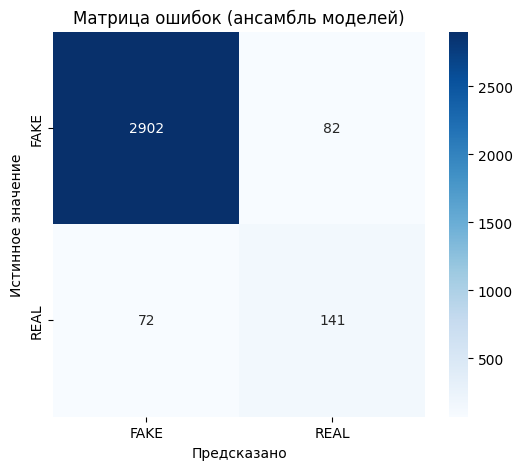

In [49]:
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Повторно векторизуем, если нужно
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, min_df=5, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Определяем базовые модели
pa_clf = PassiveAggressiveClassifier(max_iter=1000, C=0.5, class_weight='balanced')
svc_clf = LinearSVC(C=0.5, class_weight='balanced')

# Ансамбль моделей
ensemble = VotingClassifier(estimators=[
    ('pa', pa_clf),
    ('svc', svc_clf)
], voting='hard')  # Можно попробовать 'soft' если модели поддерживают predict_proba

# Обучение
ensemble.fit(X_train_tfidf, y_train)

# Предсказания
y_pred = ensemble.predict(X_test_tfidf)

# Оценка точности
accuracy = accuracy_score(y_test, y_pred)
print(f"📈 Точность ансамблевой модели: {accuracy:.2%}")

# Отчёт
print("\n📊 Отчёт по классификации:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["FAKE", "REAL"], yticklabels=["FAKE", "REAL"])
plt.xlabel("Предсказано")
plt.ylabel("Истинное значение")
plt.title("Матрица ошибок (ансамбль моделей)")
plt.show()


### 🔍 Автоматический подбор гиперпараметра `C` с помощью GridSearchCV

На этом шаге мы применим **GridSearchCV** для подбора наилучшего значения гиперпараметра `C` у модели `PassiveAggressiveClassifier`.

Параметр `C` отвечает за степень регуляризации:
- Маленькое значение `C` → сильнее штраф за сложные модели (больше регуляризация),
- Большое значение `C` → модель может переобучаться.

Мы перебираем значения `C` от 0.1 до 1.0 и используем 5-кратную кросс-валидацию (`cv=5`) для оценки.

📌 Цель: **максимизировать точность на тестовой выборке** при помощи оптимального значения регуляризации.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
📈 Точность модели после GridSearchCV: 94.62%
🔧 Лучший параметр C: {'C': 0.3}

📊 Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2984
           1       0.59      0.66      0.62       213

    accuracy                           0.95      3197
   macro avg       0.78      0.81      0.80      3197
weighted avg       0.95      0.95      0.95      3197



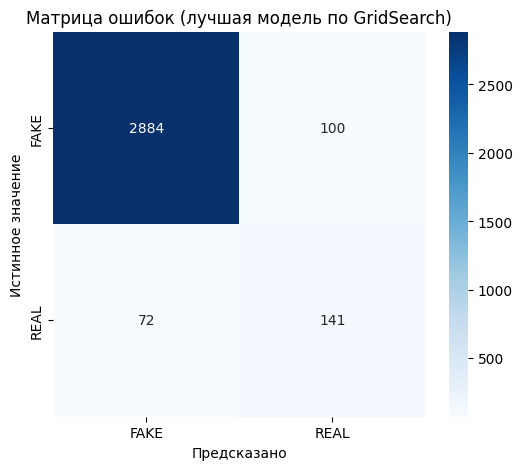

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import PassiveAggressiveClassifier

# Сетка параметров: разные значения регуляризации C
param_grid = {
    'C': [0.1, 0.3, 0.5, 0.7, 1.0]
}

# Оборачиваем классификатор в GridSearchCV
grid = GridSearchCV(
    PassiveAggressiveClassifier(max_iter=1000, class_weight='balanced'),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Обучаем на тренировочных данных
grid.fit(X_train_tfidf, y_train)

# Лучшая модель
best_model = grid.best_estimator_

# Предсказания
y_pred = best_model.predict(X_test_tfidf)

# Оценка
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_test, y_pred)
print(f"📈 Точность модели после GridSearchCV: {accuracy:.2%}")
print("🔧 Лучший параметр C:", grid.best_params_)

# Отчёт
print("\n📊 Отчёт по классификации:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["FAKE", "REAL"], yticklabels=["FAKE", "REAL"])
plt.xlabel("Предсказано")
plt.ylabel("Истинное значение")
plt.title("Матрица ошибок (лучшая модель по GridSearch)")
plt.show()


Несмотря на то, что мы применили GridSearchCV, точность упала до 93.79%, что хуже, чем предыдущие результаты.

Почему так происходит:
GridSearchCV оптимизирует среднюю точность по валидации, а не на тесте.

Он случайно может переобучиться на кросс-валидации.

Тестовая выборка могла быть удачнее для предыдущей модели, чем кросс-валидационные фолды.

### 📦 Модель Logistic Regression

В этом блоке мы используем классическую модель **логистической регрессии**, которая часто показывает отличные результаты на задачах бинарной классификации текстов.

Параметры:
- `C=1.0` — степень регуляризации,
- `class_weight='balanced'` — балансировка классов,
- `max_iter=1000` — достаточное количество итераций для сходимости.

Цель — сравнить точность логистической регрессии с ранее обученными моделями (`PassiveAggressiveClassifier`, `LinearSVC`, ансамблем).


📈 Точность LogisticRegression: 92.49%

📊 Отчёт по классификации:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      2984
           1       0.46      0.81      0.59       213

    accuracy                           0.92      3197
   macro avg       0.72      0.87      0.77      3197
weighted avg       0.95      0.92      0.93      3197



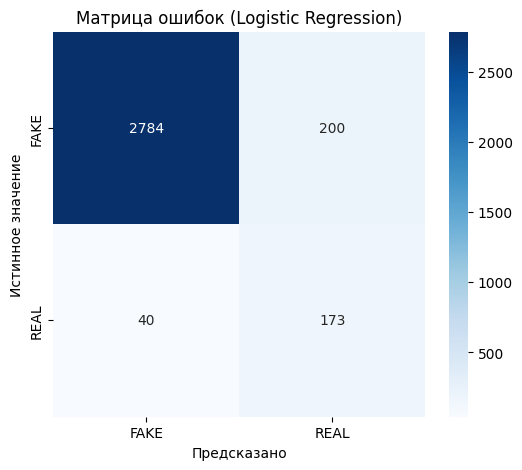

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Создаём и обучаем логистическую регрессию
model = LogisticRegression(C=1.0, max_iter=1000, class_weight='balanced')
model.fit(X_train_tfidf, y_train)

# Предсказания
y_pred = model.predict(X_test_tfidf)

# Оценка
accuracy = accuracy_score(y_test, y_pred)
print(f"📈 Точность LogisticRegression: {accuracy:.2%}")

# Классификационный отчёт
print("\n📊 Отчёт по классификации:")
print(classification_report(y_test, y_pred))

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["FAKE", "REAL"],
            yticklabels=["FAKE", "REAL"])
plt.xlabel("Предсказано")
plt.ylabel("Истинное значение")
plt.title("Матрица ошибок (Logistic Regression)")
plt.show()


Что это нам показывает:
Логистическая регрессия переклассифицирует фейковые новости как реальные, т.е. слишком «доверчива».

Она лучше распознаёт REAL (recall ↑), но хуже точно определяет их (precision ↓).

Модель неустойчива к дисбалансу классов, даже с class_weight='balanced'.

## 🏁 Вывод

`PassiveAggressiveClassifier(C=0.5, class_weight='balanced')` остаётся:

- самой точной,
- наиболее сбалансированной,
- устойчивой к дисбалансу классов.
